In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import munkres
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def is_dense(x):
    return True if str(x)[37:].split(' ')[0]=='Dense' else False

#Wagi - MSE
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            x=x.weights[0]
            y=y.weights[0]
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
                
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))
            group_dead, group_undead=[], []
            cos_sim=tf.keras.losses.CosineSimilarity(-1)
            
            for i in range(ln):
                group_dead.append(x[:,i])
                group_undead.append(y[:,i])
            
            hungary=[]
            for i, d_el in enumerate(group_dead):
                hungary.append([])
                for j, u_el in enumerate(group_undead):
                    # Gdyby to faktycznie było cosine similarity, tu powinien być minus;
                    # Ale to nie jest cosine similarity, to jest -cosine similarity z tensorflowa jako f. kosztu
                    hungary[i].append(cos_sim(d_el, u_el).numpy())
                    
            m = munkres.Munkres()
            indexes = m.compute(hungary)
            cols=[v for w, v in indexes]
            transformator_lefty=np.zeros(shape=(ln, ln), dtype='float32')
            transformator_righty=np.zeros(shape=(ln, ln), dtype='float32')
            for i, v in enumerate(cols):
                transformator_lefty[v,i]=1
                transformator_righty[i,v]=1
            
            eld=y@transformator_lefty
            if (ij<len(dead_model.layers)-1):
                if ij<len(dead_model.layers)-1 and is_dense(dead_model.layers[ij+1]):
                    neue=transformator_righty@undead_model.layers[ij+1].weights[0]
                elif ij<len(dead_model.layers)-2 and is_dense(dead_model.layers[ij+2]):
                    neue=transformator_righty@undead_model.layers[ij+2].weights[0]
                elif ij<len(dead_model.layers)-3 and is_dense(dead_model.layers[ij+3]):
                    neue=transformator_righty@undead_model.layers[ij+3].weights[0]
            
            better_numerator+=tf.reduce_sum((x-eld)*(x-eld))
            denominator+=(x.shape[0]*x.shape[1])
            print (f'LOG normal:    {tf.reduce_sum((x-y)*(x-y))/(x.shape[0]*x.shape[1])}')
            print (f'LOG hungarian: {tf.reduce_sum((x-eld)*(x-eld))/(x.shape[0]*x.shape[1])}')
    return worse_numerator/denominator, better_numerator/denominator

In [3]:
def model_generator1(dropout_rate=0.0, bnorm=False, momentum=0.99):
    lst=[
        tf.keras.layers.Dense(50, activation="sigmoid", name="alpha"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(100, activation="sigmoid", name="beta"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(100, activation="relu", name="gamma"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(100, activation="tanh", name="delta"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(5, activation="sigmoid", name="epsilon"),
    ]
    if bnorm==True:
        for i in range(len(lst)//2):
            lst.insert(i*3+1, tf.keras.layers.BatchNormalization(momentum=momentum))
    
    return tf.keras.Sequential(lst)

In [36]:
def generate_system(inputs, instances, neural):
    tx=tf.random.normal((instances, inputs))
    return tx, neural(tx)

def testo(eval_set, ideal_y, neural):
    predicted_y=neural(eval_set)
    optim=tf.keras.losses.MeanSquaredError()
    return optim(predicted_y, ideal_y)

def generate_all_models(sol_type, weight_decay=None, batch_size=32, **kwargs):
    train_instances_no, test_instances_no, inputs=100000, 10000, 10
    ideal = model_generator1(**kwargs)
    training_x, training_y = generate_system(inputs, train_instances_no, ideal)
    test_x, test_y = generate_system(inputs, test_instances_no, ideal)
    system=training_x, training_y, test_x, test_y
    print('Watever')
    
    training_x, training_y , test_x, test_y = system
    results={}
    
    if weight_decay is not None:
        optimizers=[['sgdw', tf.keras.optimizers.SGD(weight_decay)], ['adamw', tfa.optimizers.AdamW(weight_decay)]]
    else:
        optimizers=[['sgd', tf.keras.optimizers.SGD()], ['adam', tf.keras.optimizers.Adam()], ['adamw', tfa.optimizers.AdamW(0.0001)]]
    
    
    for opt in optimizers:
        imperfect = model_generator1(**kwargs)
        imperfect.compile(optimizer=opt[1], loss='mse')
        imperfect.fit(training_x.numpy(), training_y.numpy(), epochs=3, batch_size=batch_size)
        results_train = testo(training_x, training_y, imperfect)
        results_test = testo(test_x, test_y, imperfect)
        print(f"TRAINO {opt[0]}: {results_train}")
        print(f"TESTO {opt[0]}:  {results_test}")
        
        post_fact=[kwargs[v] for v in kwargs]
        print(post_fact, [opt[0], weight_decay, batch_size])
        real_fact=[sol_type, opt[0], weight_decay, batch_size]
        real_fact.extend((post_fact))
        results[tuple(real_fact)]=(results_train, results_test, kost(ideal, imperfect))
    return results
    

signification={}
for i in range(0, 6):
    signification={**signification, **generate_all_models(sol_type='dropout', dropout_rate=i/10)}
    
#for i in range(2, 9):
#    for j in [0.1, 0.5, 0.8, 0.9, 0.95, 0.99, 0.999]:
#        generate_all_models(system, batch_size=2**i, bnorm=True, momentum=j)

dissolution=[0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for i in dissolution:
    signification={**signification, **generate_all_models(sol_type='weight_decay', weight_decay=i)}

Watever
Epoch 1/3
3125/3125 [==============================] - 2s 641us/step - loss: 0.0011
Epoch 2/3
3125/3125 [==============================] - 2s 673us/step - loss: 4.9977e-05
Epoch 3/3
3125/3125 [==============================] - 2s 652us/step - loss: 4.8203e-05
TRAINO sgd: 4.7425572120118886e-05
TESTO sgd:  4.7053868911461905e-05
[0.0] ['sgd', None, 32]
Processed layer: 0
LOG normal:    0.06853194534778595
LOG hungarian: 0.027257148176431656
Processed layer: 1
Processed layer: 2
LOG normal:    0.02498701401054859
LOG hungarian: 0.017954247072339058
Processed layer: 3
Processed layer: 4
LOG normal:    0.019286446273326874
LOG hungarian: 0.015131331980228424
Processed layer: 5
Processed layer: 6
LOG normal:    0.019212886691093445
LOG hungarian: 0.0154342669993639
Processed layer: 7
Processed layer: 8
LOG normal:    0.04007142037153244
LOG hungarian: 0.0348372720181942
Epoch 1/3
3125/3125 [==============================] - 2s 714us/step - loss: 5.3712e-05
Epoch 2/3
3125/3125 [=====

3125/3125 [==============================] - 2s 714us/step - loss: 0.0026
TRAINO sgd: 0.0011961284326389432
TESTO sgd:  0.0011962993303313851
[0.3] ['sgd', None, 32]
Processed layer: 0
LOG normal:    0.0748809203505516
LOG hungarian: 0.026834625750780106
Processed layer: 1
Processed layer: 2
LOG normal:    0.024221710860729218
LOG hungarian: 0.017964189872145653
Processed layer: 3
Processed layer: 4
LOG normal:    0.01961137168109417
LOG hungarian: 0.015158056281507015
Processed layer: 5
Processed layer: 6
LOG normal:    0.018892746418714523
LOG hungarian: 0.015065191313624382
Processed layer: 7
Processed layer: 8
LOG normal:    0.030169028788805008
LOG hungarian: 0.027352573350071907
Epoch 1/3
3125/3125 [==============================] - 2s 702us/step - loss: 2.6884e-04
Epoch 2/3
3125/3125 [==============================] - 2s 713us/step - loss: 2.7675e-05
Epoch 3/3
3125/3125 [==============================] - 2s 702us/step - loss: 2.6235e-05
TRAINO adam: 2.5907760573318228e-05
TESTO 

LOG normal:    0.026901928707957268
LOG hungarian: 0.018105078488588333
Processed layer: 3
Processed layer: 4
LOG normal:    0.01933523826301098
LOG hungarian: 0.015329382382333279
Processed layer: 5
Processed layer: 6
LOG normal:    0.019519764930009842
LOG hungarian: 0.01544706430286169
Processed layer: 7
Processed layer: 8
LOG normal:    0.03673119470477104
LOG hungarian: 0.03544308617711067
Epoch 1/3
3125/3125 [==============================] - 2s 764us/step - loss: 0.0123
Epoch 2/3
3125/3125 [==============================] - 2s 770us/step - loss: 0.0123
Epoch 3/3
3125/3125 [==============================] - 2s 769us/step - loss: 0.0123
TRAINO adamw: 0.012303502298891544
TESTO adamw:  0.012310279533267021
[] ['adamw', 0.5, 32]
Processed layer: 0
LOG normal:    0.030062872916460037
LOG hungarian: 0.030062872916460037
Processed layer: 1
Processed layer: 2
LOG normal:    0.0
LOG hungarian: 0.0
Processed layer: 3
Processed layer: 4
LOG normal:    0.0
LOG hungarian: 0.0
Processed layer

Epoch 1/3
3125/3125 [==============================] - 2s 734us/step - loss: 0.0117
Epoch 2/3
3125/3125 [==============================] - 2s 776us/step - loss: 0.0108
Epoch 3/3
3125/3125 [==============================] - 2s 764us/step - loss: 0.0099
TRAINO sgdw: 0.00954563170671463
TESTO sgdw:  0.00954493135213852
[] ['sgdw', 1e-05, 32]
Processed layer: 0
LOG normal:    0.05886119604110718
LOG hungarian: 0.026734065264463425
Processed layer: 1
Processed layer: 2
LOG normal:    0.027043133974075317
LOG hungarian: 0.017915869131684303
Processed layer: 3
Processed layer: 4
LOG normal:    0.01972173899412155
LOG hungarian: 0.015279708430171013
Processed layer: 5
Processed layer: 6
LOG normal:    0.01948576793074608
LOG hungarian: 0.015317761339247227
Processed layer: 7
Processed layer: 8
LOG normal:    0.03355329483747482
LOG hungarian: 0.032457515597343445
Epoch 1/3
3125/3125 [==============================] - 2s 732us/step - loss: 1.5390e-05
Epoch 2/3
3125/3125 [=======================

In [37]:
#print(signification)
results={}
for x in signification:
    title=x[0] # Nazwa tuningu
    subtitle=x[1] # Nazwa grada
    if (title=='weight_decay'):
        value=x[2]
    if (title=='dropout'):
        value=x[4]
    
    if title not in results:
        results[title]={}
        
    if subtitle in results[title]:
        results[title][subtitle][title].append(value)
        results[title][subtitle]['train_y'].append(signification[x][0].numpy())
        results[title][subtitle]['test_y'].append(signification[x][1].numpy())
        results[title][subtitle]['w'].append(signification[x][2][1].numpy())
    else:
        results[title][subtitle]={}
        results[title][subtitle][title]=[value]
        results[title][subtitle]['train_y']=[signification[x][0].numpy()]
        results[title][subtitle]['test_y']=[signification[x][1].numpy()]
        results[title][subtitle]['w']=[signification[x][2][1].numpy()]
        
print(results)

{'dropout': {'sgd': {'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], 'train_y': [4.7425572e-05, 5.253996e-05, 0.00031189408, 0.0011961284, 0.0016610923, 0.0006064013], 'test_y': [4.705387e-05, 5.244954e-05, 0.0003128703, 0.0011962993, 0.0016574061, 0.00060544885], 'w': [0.016402863, 0.016239593, 0.016312057, 0.016121041, 0.016004628, 0.016029736]}, 'adam': {'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], 'train_y': [2.3067146e-07, 4.343033e-06, 2.6459002e-05, 2.590776e-05, 3.0486255e-05, 6.0853054e-05], 'test_y': [2.3369775e-07, 4.264818e-06, 2.648266e-05, 2.6296959e-05, 3.0083931e-05, 6.0955936e-05], 'w': [0.01625474, 0.018078884, 0.015148903, 0.01496447, 0.014682238, 0.014518821]}, 'adamw': {'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], 'train_y': [3.2345687e-07, 3.951869e-06, 2.6602875e-05, 2.6044054e-05, 3.0474692e-05, 6.0210125e-05], 'test_y': [3.2240473e-07, 3.861496e-06, 2.6598394e-05, 2.646013e-05, 3.006323e-05, 6.0419512e-05], 'w': [0.0034936615, 0.0056884685, 0.0027450363, 0.0027196226, 0

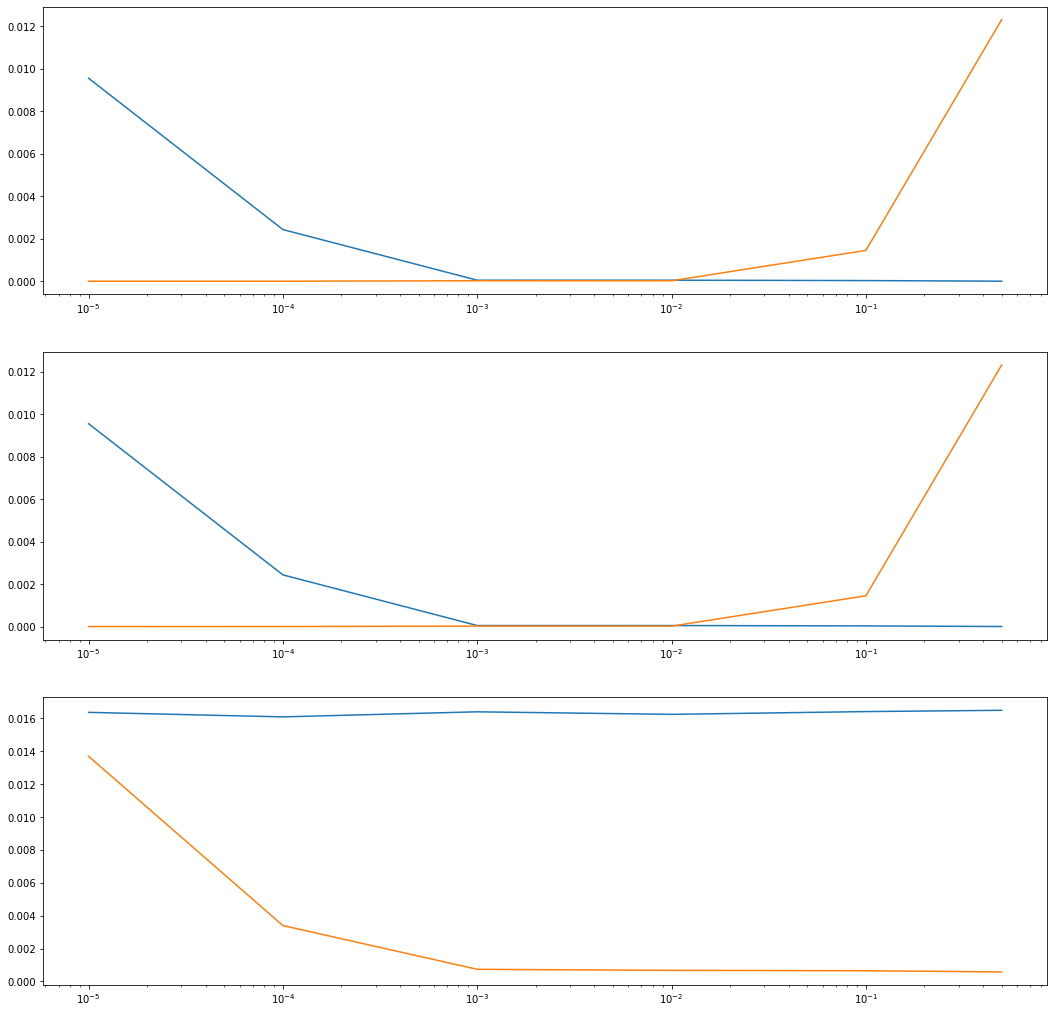

In [38]:
fig, ax=plt.subplots(3, 1, figsize=(18, 18))
for i in range(3):
        ax[i].set_xscale('log')
        
for y in ['weight_decay']
for x in results['weight_decay']:
    ax[0].plot(results['weight_decay'][x]['weight_decay'], results['weight_decay'][x]['train_y'])
    ax[1].plot(results['weight_decay'][x]['weight_decay'], results['weight_decay'][x]['test_y'])
    ax[2].plot(results['weight_decay'][x]['weight_decay'], results['weight_decay'][x]['w'])
    
plt.show()

In [7]:
tf.__version__
#print(model.layers[1].bias.numpy())
#print(model.layers[1].weights)
#print(outer)

'2.3.0'

In [74]:
matrix = [[5, 9, 1],
          [10, 3, 2],
          [8, 7, 4]]

m = munkres.Munkres()
indexes = m.compute(matrix)
print(indexes)

[(0, 2), (1, 1), (2, 0)]
